In [9]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

In [12]:
kaggle_json=json.load(open('/content/kaggle (8).json'))
os.environ['KAGGLE_USERNAME']=kaggle_json['username']
os.environ['KAGGLE_KEY']=kaggle_json['key']


In [13]:

!kaggle datasets download sabari50312/fundus-pytorch


Dataset URL: https://www.kaggle.com/datasets/sabari50312/fundus-pytorch
License(s): apache-2.0


In [15]:
from zipfile import ZipFile as ZipFile

In [17]:
with ZipFile('/content/fundus-pytorch.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [18]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/content/train'
folder_list = os.listdir(train_path)
label_map = {
    "0":"Glaucoma Present",
    "1":"Glaucoma not Present",
}
for folder in label_map:
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [19]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/content/val'
for folder in label_map:
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [20]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/content/test'
for folder in label_map:
    img_path = os.path.join(test_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

In [21]:
train_df.head()

,path,label,class_id
0,/content/train/0/BEH-322.png,Glaucoma Present,0
1,/content/train/0/G1020-247.png,Glaucoma Present,0
2,/content/train/0/REFUGE1-train-165.png,Glaucoma Present,0
3,/content/train/0/OIA-ODIR-TEST-ONLINE-696.png,Glaucoma Present,0
4,/content/train/0/ORIGA-498.png,Glaucoma Present,0


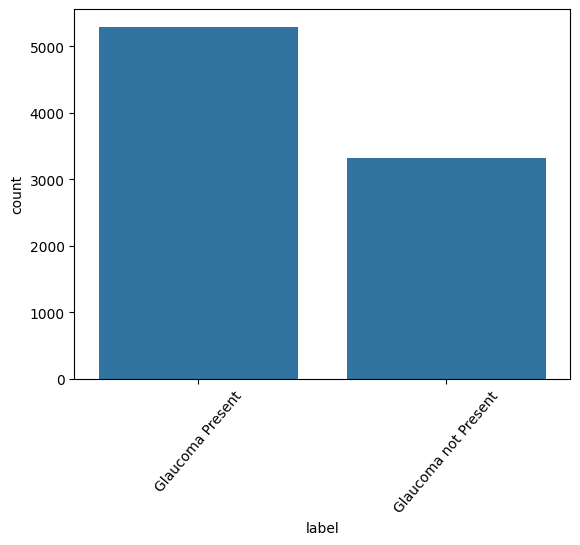

In [22]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50);

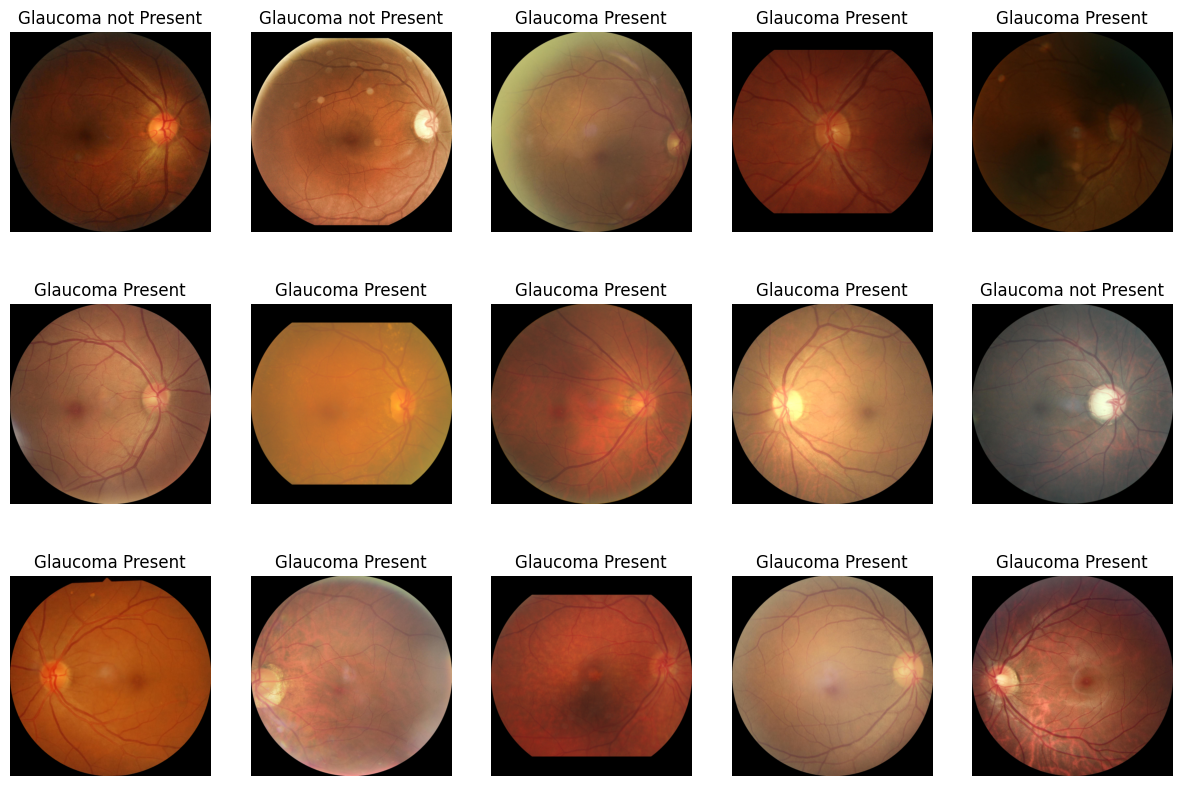

In [23]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [24]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [25]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [26]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [27]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:8621
val data:5747


In [ ]:


# Prepare data loaders
BATCH_SIZE = 32
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class CNN_RNN_Model(nn.Module):
    def __init__(self, class_size, hidden_size=256, num_layers=2): # Changed _init_ to __init__
        super(CNN_RNN_Model, self).__init__()
        # Pre-trained EfficientNet as feature extractor
        self.cnn = models.efficientnet_v2_s(weights='DEFAULT')
        self.cnn.classifier = nn.Identity()  # Remove the classifier

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=1280,  # Feature vector size from EfficientNet
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, class_size)  # 2 for bidirectional LSTM

    def forward(self, x):
        batch_size = x.size(0)

        # Feature extraction using EfficientNet
        features = self.cnn(x)
        features = features.view(batch_size, 1, -1)  # Reshape for LSTM

        # LSTM processing
        lstm_out, _ = self.lstm(features)
        lstm_out = lstm_out[:, -1, :]  # Take last output of sequence

        # Fully connected layer
        out = self.fc(lstm_out)

        return out

# Initialize model, loss function, optimizer
class_size = 2
model = CNN_RNN_Model(class_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7, 14, 21, 28, 35], gamma=0.1)

# Training function
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0

    for data_, target_ in dataloader:
        target_ = target_.type(torch.LongTensor).to(device)
        data_ = data_.to(device)

        optimizer.zero_grad()
        outputs = model(data_)
        loss = loss_fn(outputs, target_)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        epoch_correct += torch.sum(pred == target_).item()

    lr_scheduler.step()
    return epoch_correct / size, epoch_loss / num_batches

# Validation function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0.0
    epoch_correct = 0

    with torch.no_grad():
        model.eval()
        for data_, target_ in dataloader:
            target_ = target_.type(torch.LongTensor).to(device)
            data_ = data_.to(device)

            outputs = model(data_)
            loss = loss_fn(outputs, target_)

            epoch_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            epoch_correct += torch.sum(pred == target_).item()

    return epoch_correct / size, epoch_loss / num_batches

# Training loop
EPOCHS = 50
logs = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

best_loss = np.inf
patience = 5
counter = 0

if not os.path.exists('checkpoints'):
    os.mkdir("checkpoints")

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)

    print(f'EPOCH: {epoch} | train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "checkpoints/last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping!")
        break

# Load best model and evaluate
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for data_, target_ in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor).to(device)
        data_ = data_.to(device)
        outputs = model(data_)
        _, pred = torch.max(outputs, dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

print("Model evaluation completed!")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0 | train_loss: 0.5019, train_acc: 0.757 | val_loss: 0.3263, val_acc: 0.857


  2%|▏         | 1/50 [05:38<4:36:16, 338.30s/it]

EPOCH: 1 | train_loss: 0.3996, train_acc: 0.823 | val_loss: 0.2790, val_acc: 0.886


  4%|▍         | 2/50 [11:00<4:22:59, 328.74s/it]

EPOCH: 2 | train_loss: 0.3742, train_acc: 0.835 | val_loss: 0.2689, val_acc: 0.888


  6%|▌         | 3/50 [16:16<4:13:07, 323.13s/it]

EPOCH: 3 | train_loss: 0.3545, train_acc: 0.843 | val_loss: 0.2569, val_acc: 0.896


  8%|▊         | 4/50 [21:32<4:05:27, 320.16s/it]

EPOCH: 4 | train_loss: 0.3353, train_acc: 0.855 | val_loss: 0.2507, val_acc: 0.898


 10%|█         | 5/50 [26:46<3:58:25, 317.90s/it]

EPOCH: 5 | train_loss: 0.3224, train_acc: 0.860 | val_loss: 0.2132, val_acc: 0.914


 12%|█▏        | 6/50 [32:02<3:52:46, 317.43s/it]

EPOCH: 6 | train_loss: 0.3164, train_acc: 0.865 | val_loss: 0.2006, val_acc: 0.919


 14%|█▍        | 7/50 [37:16<3:46:32, 316.11s/it]

EPOCH: 7 | train_loss: 0.2915, train_acc: 0.876 | val_loss: 0.1902, val_acc: 0.921


 16%|█▌        | 8/50 [42:28<3:40:25, 314.89s/it]

EPOCH: 8 | train_loss: 0.2755, train_acc: 0.881 | val_loss: 0.1839, val_acc: 0.924


 18%|█▊        | 9/50 [47:41<3:34:44, 314.25s/it]

EPOCH: 9 | train_loss: 0.2662, train_acc: 0.884 | val_loss: 0.1781, val_acc: 0.926


 20%|██        | 10/50 [52:55<3:29:30, 314.27s/it]

EPOCH: 10 | train_loss: 0.2607, train_acc: 0.888 | val_loss: 0.1740, val_acc: 0.928


 22%|██▏       | 11/50 [58:10<3:24:25, 314.49s/it]

EPOCH: 11 | train_loss: 0.2568, train_acc: 0.889 | val_loss: 0.1681, val_acc: 0.931


 24%|██▍       | 12/50 [1:03:26<3:19:31, 315.03s/it]

EPOCH: 12 | train_loss: 0.2531, train_acc: 0.889 | val_loss: 0.1616, val_acc: 0.934


 26%|██▌       | 13/50 [1:08:41<3:14:05, 314.75s/it]

EPOCH: 13 | train_loss: 0.2439, train_acc: 0.894 | val_loss: 0.1514, val_acc: 0.937


 28%|██▊       | 14/50 [1:13:46<3:07:10, 311.94s/it]

EPOCH: 14 | train_loss: 0.2398, train_acc: 0.898 | val_loss: 0.1516, val_acc: 0.938


 30%|███       | 15/50 [1:18:52<3:00:54, 310.14s/it]

EPOCH: 15 | train_loss: 0.2422, train_acc: 0.892 | val_loss: 0.1521, val_acc: 0.938


 32%|███▏      | 16/50 [1:24:04<2:56:05, 310.74s/it]

EPOCH: 16 | train_loss: 0.2423, train_acc: 0.897 | val_loss: 0.1502, val_acc: 0.938


 34%|███▍      | 17/50 [1:29:10<2:50:07, 309.31s/it]

EPOCH: 17 | train_loss: 0.2366, train_acc: 0.898 | val_loss: 0.1529, val_acc: 0.936


 36%|███▌      | 18/50 [1:34:16<2:44:28, 308.38s/it]

EPOCH: 18 | train_loss: 0.2394, train_acc: 0.899 | val_loss: 0.1476, val_acc: 0.940


 38%|███▊      | 19/50 [1:39:22<2:38:58, 307.70s/it]

EPOCH: 19 | train_loss: 0.2390, train_acc: 0.896 | val_loss: 0.1472, val_acc: 0.939


 40%|████      | 20/50 [1:44:32<2:34:06, 308.21s/it]

EPOCH: 20 | train_loss: 0.2374, train_acc: 0.897 | val_loss: 0.1514, val_acc: 0.937


 42%|████▏     | 21/50 [1:49:39<2:28:49, 307.90s/it]

EPOCH: 21 | train_loss: 0.2426, train_acc: 0.894 | val_loss: 0.1486, val_acc: 0.939


 44%|████▍     | 22/50 [1:54:58<2:25:12, 311.17s/it]

EPOCH: 22 | train_loss: 0.2403, train_acc: 0.896 | val_loss: 0.1493, val_acc: 0.939


 46%|████▌     | 23/50 [2:00:15<2:20:50, 313.00s/it]